In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.layers import Dense,Dropout,Flatten,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,auc,roc_auc_score,roc_curve
np.random.seed(42)
tf.random.set_seed(42)



In [7]:
tf.__version__

'2.19.0'

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [16]:
import os

print(os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train"))


['PNEUMONIA', 'NORMAL']


In [14]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

# Check directory structure
print("Dataset Structure:")
for folder in ['train', 'test', 'val']:
    folder_path = os.path.join(base_dir, folder)
    print(f"\n{folder.upper()}:")
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        num_images = len(os.listdir(category_path))
        print(f"  {category}: {num_images} images")

# Define directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

Dataset Structure:

TRAIN:
  PNEUMONIA: 3875 images
  NORMAL: 1341 images

TEST:
  PNEUMONIA: 390 images
  NORMAL: 234 images

VAL:
  PNEUMONIA: 8 images
  NORMAL: 8 images


In [21]:
def plot_samples(directory,num_samples=8):
    normal_dir=os.path.join(directory,'NORMAL')
    pneumonia_dir=os.path.join(directory,'PNEUMONIA')
    fig,axes=plt.subplots(2,4,figsize=(15,8))
    normal_images=os.listdir(normal_dir)[:4]
    for i , img_name in enumerate(normal_images):
        img_path=os.path.join(normal_dir,img_name)
        img=Image.open(img_path)
        axes[0,i].imshow(img,cmap='gray')
        axes[0,i].set_title(f"Normal\n{img.size}")
        axes[0,i].axis("off")
    pnuemonia_images=os.listdir(pneumonia_dir)[:4]
    for i ,img_name in enumerate(pnuemonia_images):
        img_path=os.path.join(pneumonia_dir,img_name)
        img=Image.open(img_path)
        axes[1,i].imshow(img,cmap='gray')
        axes[1,i].set_title(f'PNUEMONIA\n{img.size}')
        axes[1,i].axis('off')
    plt.tight_layout()
    plt.show()

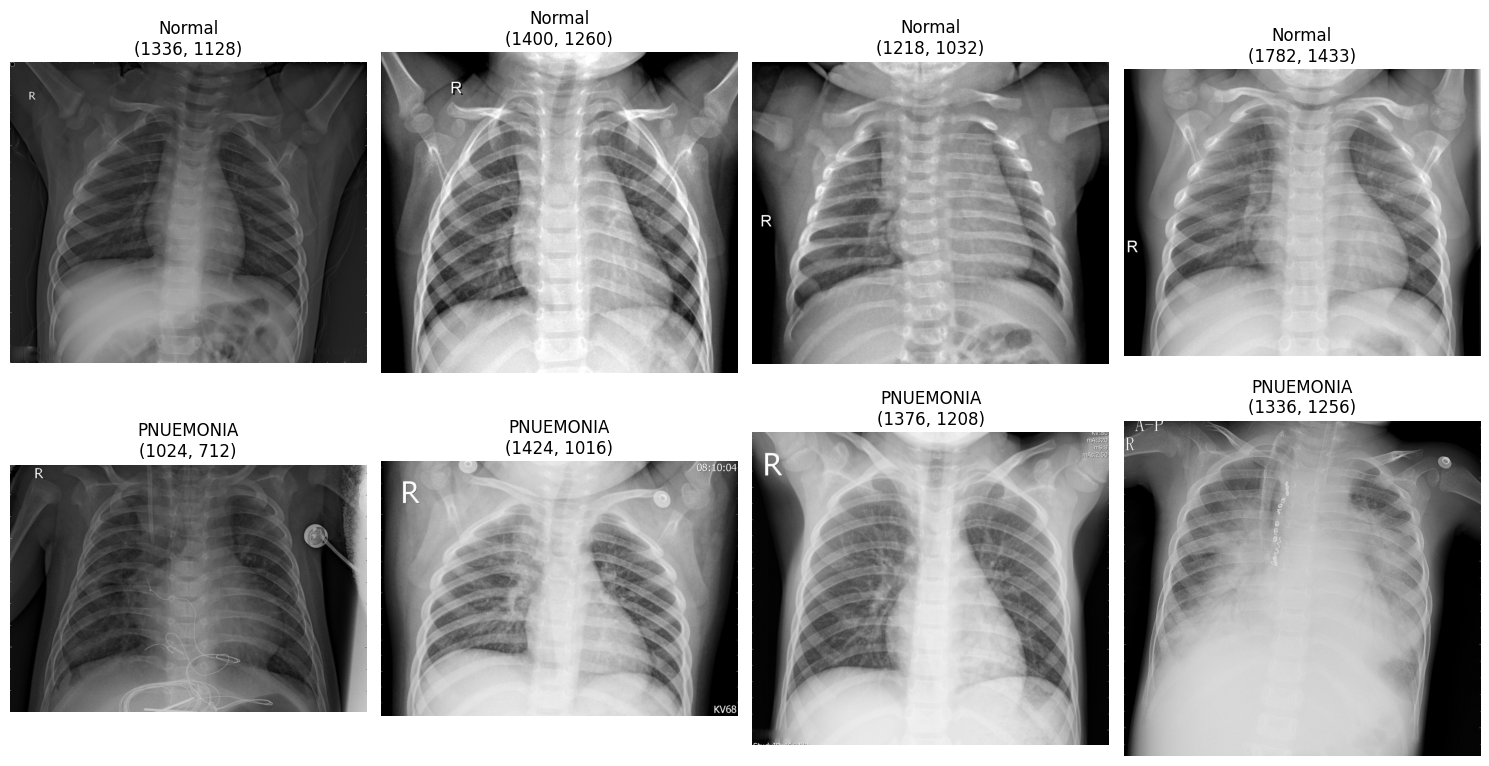

In [22]:
plot_samples(train_dir)

In [24]:
IMG_HEIGHT=224
IMG_WIDTH=224
BATCH_SIZE=32

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen=ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)
val_generator=val_test_datagen.flow_from_directory(
    val_dir,target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
print(f"\nClass Indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624


In [26]:
def build_vgg16_model():
    # Load pre-trained VGG16 without top layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

# Uncomment to use VGG16 instead of simple CNN
model = build_vgg16_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [27]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy',keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       keras.metrics.AUC(name='auc')]
              )

In [28]:
callbacks=[
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_pneumonia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,verbose=1
    )
]

In [ ]:
EPOCHS=50
history=model.fit(train_generator,epochs=EPOCHS,
                  validation_data=val_generator,
                  callbacks=callbacks,
                  verbose=1
                  )
print("\nTraining completed!")
model.save('pneumonia_detector.h5')


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7184 - auc: 0.8298 - loss: 0.6190 - precision: 0.9206 - recall: 0.6795 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 3273s 20s/step - accuracy: 0.7188 - auc: 0.8303 - loss: 0.6183 - precision: 0.9209 - recall: 0.6800 - val_accuracy: 0.5000 - val_auc: 0.9141 - val_loss: 0.6780 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
153/163 ━━━━━━━━━━━━━━━━━━━━ 3:20 20s/step - accuracy: 0.8615 - auc: 0.9481 - loss: 0.3687 - precision: 0.9708 - recall: 0.8367

154/163 ━━━━━━━━━━━━━━━━━━━━ 3:01 20s/step - accuracy: 0.8615 - auc: 0.9481 - loss: 0.3686 - precision: 0.9708 - recall: 0.8368

: 

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
test_loss,test_acc,test_precision,test_recall,test_auc=model.evaluate(test_generator)


In [ ]:


# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"\n{'='*50}")
print(f"TEST SET RESULTS:")
print(f"{'='*50}")
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test AUC:       {test_auc:.4f}")
print(f"{'='*50}")



In [ ]:
test_generator.reset()
y_pred_probs=model.predict(test_generator,verbose=1)
y_pred=(y_pred_probs>0.5).astype(int).flatten()
y_true=test_generator.classes
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklables=["Normal","Pneumonia"],yticklabels=['Normal','Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
print("\nClassification Report:")
print(classification_report(y_true,y_pred,target_names=['Normal',"Pneumonia"]))


In [ ]:
fpr,tpr,thresholds=roc_curve(y_true,y_pred_probs)
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC curve (AUC ={roc_auc:.4f})')
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--',label='Random Classifier')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True,alpha=0.3)
plt.show()

In [ ]:
def visualize_predictions(generator, model, num_images=12):
    generator.reset()
    x_batch, y_batch = next(generator)
    predictions = model.predict(x_batch)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    for i in range(min(num_images, len(x_batch))):
        axes[i].imshow(x_batch[i])
        
        true_label = 'Pneumonia' if y_batch[i] == 2 else 'Normal'
        pred_label = 'Pneumonia' if predictions[i] > 0.5 else 'Normal'
        confidence = predictions[i][0] if predictions[i] > 0.5 else 1 - predictions[i][0]
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.2%})', 
                         color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_generator, model)

In [ ]:
from tensorflow.keras.models import load_model


model = load_model('/kaggle/working/pneumonia_detector.h5')
def visualize_pneumonia_predictions(generator, model, num_images=12):
    """
    Visualizes model predictions for true Pneumonia cases in a test data generator.
    """
    generator.reset()
    collected = 0
    collected_x = []
    collected_true = []
    collected_pred = []

    while collected < num_images:
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch)
        for i in range(len(y_batch)):
            if y_batch[i] == 1:
                collected_x.append(x_batch[i])
                collected_true.append(y_batch[i])
                collected_pred.append(preds[i][0])
                collected += 1
                if collected >= num_images:
                    break

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    for i in range(num_images):
        axes[i].imshow(collected_x[i])
        true_label = 'Pneumonia'
        pred_label = 'Pneumonia' if collected_pred[i] > 0.5 else 'Normal'
        confidence = collected_pred[i] if collected_pred[i] > 0.5 else 1 - collected_pred[i]
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(
            f'True: {true_label}\nPred: {pred_label} ({confidence:.2%})',
            color=color, fontweight='bold'
        )
        axes[i].axis('off')

    plt.suptitle("True Pneumonia Cases: Saved Model Predictions", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Usage:
visualize_pneumonia_predictions(test_generator, model, num_images=12)

# Usage (after loading your saved model):
visualize_pneumonia_predictions(test_generator, model, num_images=12)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os


test_normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL'
test_pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'

# Pneumonia image
# img_filename = os.listdir(test_pneumonia_dir)[0]
# img_path = os.path.join(test_pneumonia_dir, img_filename)

# Normal image
# img_filename = os.listdir(test_normal_dir)[0]
# img_path = os.path.join(test_normal_dir, img_filename)
img_path = '/kaggle/input/test12/test2.jpg' 

print(f"Image path: {img_path}")

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
pred_label = 'Pneumonia' if prediction[0][0] > 0.5 else 'Normal'
confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

print(f"Prediction: {pred_label} ({confidence:.2%} confidence)")

# Visualize
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_label} ({confidence:.2%})")
plt.show()